#  Capstone Project - The Battle of Neighborhoods ( Week 2)

# Import the necessary libraries 

In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import seaborn as sns # data visualisation and modelling
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML     
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
import json # library to handle JSON files
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Folium installed')
print('Libraries imported.')

### Define Foursquare Credentials and Version

In [3]:
CLIENT_ID = 'Y5HACAVLRW3Q5GIHJLX4AAZGZAGAXDBMW243Q54KPUPYZLSS' # your Foursquare ID
CLIENT_SECRET = 'WWLJH05WFMDIGJGULGKTLE2ZS5TCJRSFDACB5TSSHNOR12C0' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100 # this can go up to 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Y5HACAVLRW3Q5GIHJLX4AAZGZAGAXDBMW243Q54KPUPYZLSS
CLIENT_SECRET:WWLJH05WFMDIGJGULGKTLE2ZS5TCJRSFDACB5TSSHNOR12C0


In [4]:
#CLIENT_ID = 'your-client-ID' # your Foursquare ID
#CLIENT_SECRET = 'your-client-secret' # your Foursquare Secret
#VERSION = '20180604'
#LIMIT = 30
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)


In order to define an instance of the geocoder, we need to define a `user_agent`. We will name our agent <em>foursquare_agent</em> and define the  `address and the search_query` which will be associated with  above mentioned creditentiels. The form of specific category is of the following from:

> `https://api.foursquare.com/v2/venues/`**search**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&query=`**QUERY**`&radius=`**RADIUS**`&limit=`**LIMIT**

In order to find the location of a specific point of interst, the following code blocks have been used.

In [5]:
# This function will get the location of a specific region of interest POI.
def get_address(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print(latitude, longitude)

In [6]:
#address = '102 North End Ave, New York, NY'
#address = 'Aalborg, 9000'
address ='Aalborg'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

57.0482206 9.9193939


Assuming that we are living in **Aalborg City** and we  need the near  **Rema1000** supermarket, one can use the following few of code to request the `json` file that contains the location of  all the near **Rema1000** supermarket.

In [7]:
address = 'Aalborg'
get_address(address) # Get the address of a specific point of interst
search_query = 'Rema1000'
radius =50000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()

57.0482206 9.9193939


In order  to convert the `json` file  to `pandas DataFrame` and filter the venues, the following function can be used

In [8]:
def format_requests_result(results):
    # keep only columns that include venue name, and anything that is associated with location
    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']
        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']
    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    dataframe_filtered = dataframe_filtered.drop(columns = ['formattedAddress','country', 'id','state', 'cc','labeledLatLngs'])
    return dataframe_filtered

In [9]:
def clean_store_name(col, df_store,store_name): # clean the rows to have unique name  example : Rema 1000, Fakta,Lidl .....
    for i in range(1, df_store.shape[0]):
        if([df_store[col] != store_name]):
            df_store[col] = store_name
   

# Get Rema1000 DataFrame using Foursquare

In [10]:
rema1000_df = format_requests_result(results)
rema1000_df.drop('crossStreet', axis =1, inplace = True)
clean_store_name('name', rema1000_df, 'REMA 1000')
rema1000_df.head()

,name,categories,address,city,distance,lat,lng,postalCode
0,REMA 1000,Discount Store,Vestergade 22,Nørresundby,1255,57.059502,9.919370,9400
1,REMA 1000,Discount Store,Godsbanen 2,Aalborg,723,57.042319,9.924412,9000
2,REMA 1000,Discount Store,Østerbro 29 A,Aalborg,1054,57.046191,9.936409,9000
3,REMA 1000,Discount Store,Danalien 1 E,Aalborg,2562,57.029152,9.943098,9000
4,REMA 1000,Discount Store,Stenbjergvej 1,Aalborg Øst,5300,57.040576,10.005793,9220


# Lidl DataFrame using Foursquare

In [11]:
address = 'Aalborg'
get_address(address)
search_query = 'Lidl'
radius =50000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
lidl_results = requests.get(url).json()
lidl_df = format_requests_result(lidl_results)
lidl_df.drop('crossStreet', axis =1, inplace = True)
clean_store_name('name',lidl_df, 'Lidl')
lidl_df.head()

57.0482206 9.9193939


,name,categories,address,city,distance,lat,lng,postalCode
0,Lidl,Discount Store,Thistedvej 1d,Nørresundby,1753,57.063187,9.910343,9400
1,Lidl,Discount Store,Diskovej 3,Aalborg,3062,57.023636,9.942100,9210
2,Lidl,Discount Store,K Christensensvej 1 - 3,Aalborg,4116,57.013425,9.896384,9000
3,Lidl,Discount Store,K. Christensens Vej 1,Aalborg SV,4138,57.013435,9.895280,9200
4,Lidl,Discount Store,Østergade 52,Brønderslev,24062,57.263749,9.949852,9700


Join  `Rema1000` to `Lidl` Dataframe

In [12]:
rema_lidl_df = rema1000_df.append(lidl_df, ignore_index= True)
rema_lidl_df.head()

,name,categories,address,city,distance,lat,lng,postalCode
0,REMA 1000,Discount Store,Vestergade 22,Nørresundby,1255,57.059502,9.919370,9400
1,REMA 1000,Discount Store,Godsbanen 2,Aalborg,723,57.042319,9.924412,9000
2,REMA 1000,Discount Store,Østerbro 29 A,Aalborg,1054,57.046191,9.936409,9000
3,REMA 1000,Discount Store,Danalien 1 E,Aalborg,2562,57.029152,9.943098,9000
4,REMA 1000,Discount Store,Stenbjergvej 1,Aalborg Øst,5300,57.040576,10.005793,9220


# Get Føtex DataFrame

In [13]:
address = 'Aalborg'
get_address(address)
search_query = 'Føtex'
radius =50000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
føtex_results = requests.get(url).json()

57.0482206 9.9193939


In [14]:
føtex_df = format_requests_result(føtex_results)
clean_store_name('name',føtex_df, 'Føtex')
føtex_df.head()

,name,categories,address,city,distance,lat,lng,postalCode
0,Føtex,Supermarket,Synergivej 5,Aalborg,1601,57.036823,9.935540,9000
1,Føtex,Supermarket,Vestergade 30,Nørresundby,1294,57.059831,9.918082,9400
2,Føtex,Supermarket,Slotsgade 8,Aalborg,333,57.047505,9.924750,9000
3,Føtex,Bistro,Slotsgade 8,Aalborg,327,57.047240,9.924501,9000
4,Føtex,Mobile Phone Shop,Slotsgade 8-14,Aalborg,471,57.048071,9.927178,9000


Append `Føtex DataFame` to `Rema-Lidl DataFrame `

In [15]:
rema_lidl_føtex_df = rema_lidl_df.append(føtex_df, ignore_index = True, sort =False)
rema_lidl_føtex_df.head()

,name,categories,address,city,distance,lat,lng,postalCode
0,REMA 1000,Discount Store,Vestergade 22,Nørresundby,1255,57.059502,9.919370,9400
1,REMA 1000,Discount Store,Godsbanen 2,Aalborg,723,57.042319,9.924412,9000
2,REMA 1000,Discount Store,Østerbro 29 A,Aalborg,1054,57.046191,9.936409,9000
3,REMA 1000,Discount Store,Danalien 1 E,Aalborg,2562,57.029152,9.943098,9000
4,REMA 1000,Discount Store,Stenbjergvej 1,Aalborg Øst,5300,57.040576,10.005793,9220


# Get Fakta DataFrame

In [16]:
address = 'Aalborg'
get_address(address)
radius =50000
search_query = 'Fakta'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
fakta_results = requests.get(url).json()
fakta_df = format_requests_result(fakta_results)
fakta_df.drop('crossStreet', axis =1, inplace = True)
clean_store_name('name', fakta_df, 'Fakta')
fakta_df.head()

57.0482206 9.9193939


,name,categories,address,city,distance,lat,lng,postalCode
0,Fakta,Grocery Store,Vestre Alle 13,Aalborg,1747,57.034044,9.906993,9000
1,Fakta,Grocery Store,Alexander Foss Gade 10,Aalborg,1713,57.035144,9.934309,9000
2,Fakta,Grocery Store,Østerbrogade 54,Nørresundby,1126,57.057933,9.924600,9400
3,Fakta,Grocery Store,Thulebakken 42,Aalborg,2503,57.035799,9.884941,9000
4,Fakta,Grocery Store,Forbindelsesvejen 148,Nørresundby,2902,57.070182,9.945253,9400


After the above-mentioned steps, one can get the  final dataset that can be used to investigate and solve the problm. The final dataset that contains **Lidl** and it's competitors. 

In [17]:
df = rema_lidl_føtex_df.append(fakta_df, ignore_index= True, sort= False)
df.dropna( axis = 0, inplace = True)
df.sort_values('name', ascending = True)
df.head()

,name,categories,address,city,distance,lat,lng,postalCode
0,REMA 1000,Discount Store,Vestergade 22,Nørresundby,1255,57.059502,9.919370,9400
1,REMA 1000,Discount Store,Godsbanen 2,Aalborg,723,57.042319,9.924412,9000
2,REMA 1000,Discount Store,Østerbro 29 A,Aalborg,1054,57.046191,9.936409,9000
3,REMA 1000,Discount Store,Danalien 1 E,Aalborg,2562,57.029152,9.943098,9000
4,REMA 1000,Discount Store,Stenbjergvej 1,Aalborg Øst,5300,57.040576,10.005793,9220


### Data  Analysis and Visualization<a name ="data_analysis"></a>

After Data wrangling or Data munging, I will now perform some exploratory Data analysis (EDA) and visualization for a better understanding dataset and try to find which Machine Learning algorithm can be suitable to for this kind of problem.

In [18]:
df_num_of_supermarket = df.groupby(['name'])['postalCode'].count().reset_index()
df_num_of_supermarket

,name,postalCode
0,Fakta,26
1,Føtex,14
2,Lidl,9
3,REMA 1000,37


Surprisingly, after a simple grouping by postalCol I realized that there are more `REMA 1000` in Aalborg city than any other supermarket while there is only **9 Lidl** supermarket. To find out where they are located, one can perform the following query

In [19]:
lidl_filtered_df = df[df['name'] == 'Lidl']
lidl_filtered_df

,name,categories,address,city,distance,lat,lng,postalCode
41,Lidl,Discount Store,Thistedvej 1d,Nørresundby,1753,57.063187,9.910343,9400
42,Lidl,Discount Store,Diskovej 3,Aalborg,3062,57.023636,9.942100,9210
43,Lidl,Discount Store,K Christensensvej 1 - 3,Aalborg,4116,57.013425,9.896384,9000
44,Lidl,Discount Store,K. Christensens Vej 1,Aalborg SV,4138,57.013435,9.895280,9200
45,Lidl,Discount Store,Østergade 52,Brønderslev,24062,57.263749,9.949852,9700
46,Lidl,Discount Store,Hostrupvej 68,Hobro,45469,56.645578,9.793760,9500
48,Lidl,Discount Store,Sæbygårdvej 29,Sæby,47406,57.333284,10.503293,9300
49,Lidl,Discount Store,Åstrupvej 2,Hjørring,45567,57.456340,9.977785,9800
51,Lidl,Discount Store,Hjørringvej 125,Frederikshavn,57039,57.447173,10.513747,9900


One can read from the table above that there is only **One (1) Lidl** store in the main city **Aalborg**,**5 of the 8** remaining stores are located very far from Aalborg center. The reasons of this choice are multiples and We will enumerate some of them in next sections. One can also Visualize all supermarkets in **Nordjylland** 

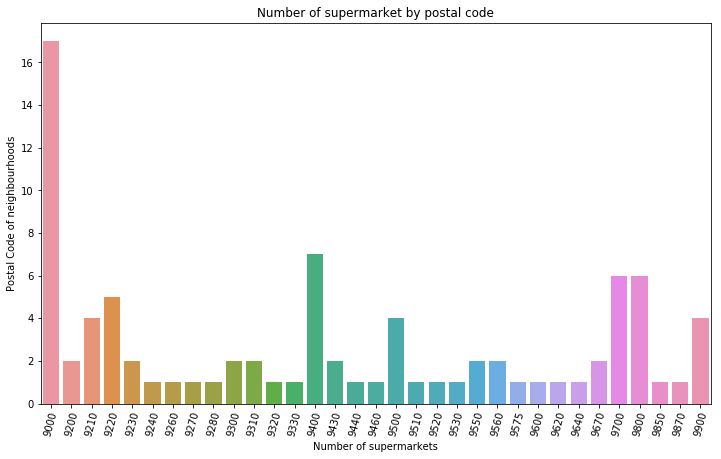

In [20]:
df_bar = df.groupby('postalCode')['name'].count().reset_index()
plt.figure(figsize=(12,7))
plt.xticks(rotation=75)
ax = sns.barplot(x = 'postalCode', y = 'name', data=df_bar)
ax.set(xlabel='Number of supermarkets', ylabel='Postal Code of neighbourhoods', title='Number of supermarket by postal code')
plt.show(ax)

Number of **LiDL**  in Aalbrog are presented in the following figure:

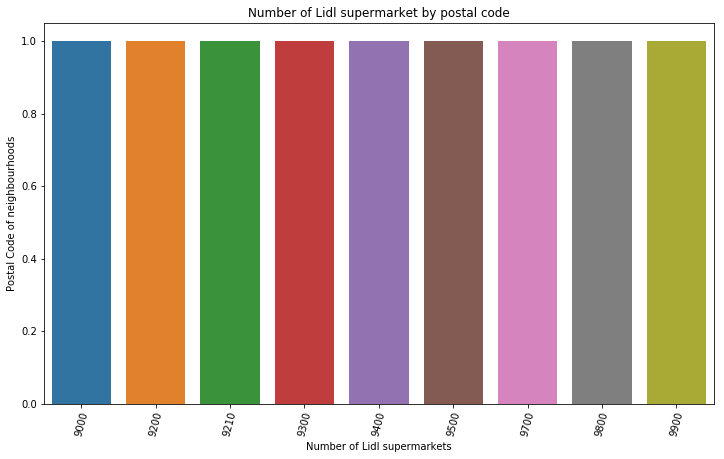

In [21]:
lidl_filtered_df = df[df['name'] == 'Lidl']
plt.figure(figsize=(12,7))
plt.xticks(rotation=75)
ax = sns.countplot(x = 'postalCode', data=lidl_filtered_df)
ax.set(xlabel='Number of Lidl supermarkets', ylabel='Postal Code of neighbourhoods', title='Number of Lidl supermarket by postal code')
plt.show(ax)

From this graph one can understand that **LIDL** have decided to build only one **Supermarket** per neighbourhood (by Postal code).The reason of this choice can be very difficult to understand specially where in main **City** where we can find only **One(1) LIDl** of 17.

The number of **supermarket** in Aalborg city.

In [22]:
df_9000 = df[df['postalCode'] == "9000"].groupby(['name'])['postalCode'].count().reset_index(inplace = False)
df_9000.sort_values('postalCode', ascending = False)

,name,postalCode
3,REMA 1000,6
0,Fakta,5
1,Føtex,5
2,Lidl,1


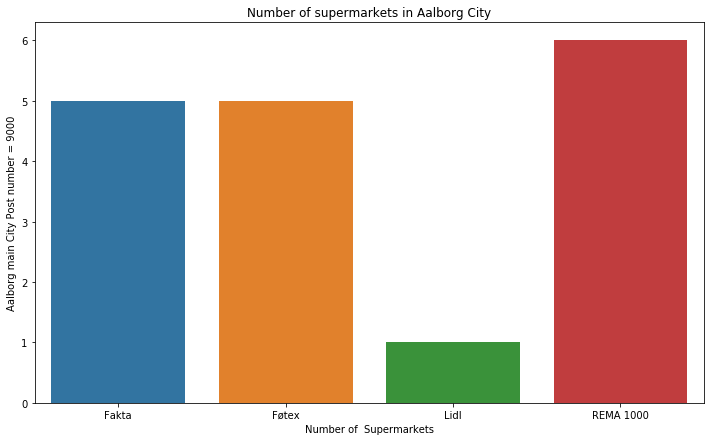

In [23]:
plt.figure(figsize=(12,7))
ax = sns.barplot( x = 'name', y= 'postalCode', data=df_9000)
ax.set(xlabel='Number of  Supermarkets', ylabel='Aalborg main City Post number = 9000', title='Number of supermarkets in Aalborg City')
plt.show(ax)

It seems that **Lidl Group** have decided to build **One (1)** store in every neighbourhood town en Aalborg region

Now one can   Create a map of Aalborg with The Suppermarkets their locations and postalCode of neighbourhood  using **folium**

In [24]:
map_aalborg = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, address, postal_c, s_name in zip(df['lat'], df['lng'], df['name'], df['address'], df['postalCode']):
    label = '{} ,{}, {}'.format(address, postal_c, s_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        tooltip = "Essai",      
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_aalborg)  
    
map_aalborg

Now try to isolate `Lidl`  and see how it is location and distance from the center of City **Aalborg**

Now we  try to isolate **Lidl** and see the different locations on map and the distance from the main  center **City Aalborg**

In [25]:
lidl_filtered_df = df[df['name'] == 'Lidl']
lidl_filtered_df

,name,categories,address,city,distance,lat,lng,postalCode
41,Lidl,Discount Store,Thistedvej 1d,Nørresundby,1753,57.063187,9.910343,9400
42,Lidl,Discount Store,Diskovej 3,Aalborg,3062,57.023636,9.942100,9210
43,Lidl,Discount Store,K Christensensvej 1 - 3,Aalborg,4116,57.013425,9.896384,9000
44,Lidl,Discount Store,K. Christensens Vej 1,Aalborg SV,4138,57.013435,9.895280,9200
45,Lidl,Discount Store,Østergade 52,Brønderslev,24062,57.263749,9.949852,9700
46,Lidl,Discount Store,Hostrupvej 68,Hobro,45469,56.645578,9.793760,9500
48,Lidl,Discount Store,Sæbygårdvej 29,Sæby,47406,57.333284,10.503293,9300
49,Lidl,Discount Store,Åstrupvej 2,Hjørring,45567,57.456340,9.977785,9800
51,Lidl,Discount Store,Hjørringvej 125,Frederikshavn,57039,57.447173,10.513747,9900


# Create map of  Aalborg to locate Lidl Supermarket

In [26]:
map_lidl = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, address, postal_c, s_name in zip(lidl_filtered_df['lat'], lidl_filtered_df['lng'], lidl_filtered_df['name'], lidl_filtered_df['address'], lidl_filtered_df['postalCode']):
    label = '{}, {}, {}'.format(address, postal_c, s_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lidl)  
    
map_lidl

### Modelling  <a name ="model"></a>

Having a better understanding dataset, an unsupervised Machine learning is a suitable to find to solve this problem. Therefore, in next step, I will build  a **k-means** algorithm using the loaction data and the distance. For this purpose I will filter the dataset and use the following  methods

In [27]:
from sklearn.cluster import KMeans
kclusters = 4 #I choose the number of cluster to see how the 4 supermarket are presented in Aalborg

clust_data = df.drop(['name','city', 'categories', 'address', 'postalCode'], axis = 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clust_data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster to the dataset.

In [28]:
df['cluster_labels'] = kmeans.labels_
df.head()

,name,categories,address,city,distance,lat,lng,postalCode,cluster_labels
0,REMA 1000,Discount Store,Vestergade 22,Nørresundby,1255,57.059502,9.919370,9400,0
1,REMA 1000,Discount Store,Godsbanen 2,Aalborg,723,57.042319,9.924412,9000,0
2,REMA 1000,Discount Store,Østerbro 29 A,Aalborg,1054,57.046191,9.936409,9000,0
3,REMA 1000,Discount Store,Danalien 1 E,Aalborg,2562,57.029152,9.943098,9000,0
4,REMA 1000,Discount Store,Stenbjergvej 1,Aalborg Øst,5300,57.040576,10.005793,9220,0


In [29]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for s_name, lat, lon, poi, cluster in zip(df['name'],df['lat'], df['lng'], df['address'], df['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [30]:
clust_lidl= df['name'] == "Lidl"
df_lidl_clust = df[clust_lidl]
df_lidl_clust

,name,categories,address,city,distance,lat,lng,postalCode,cluster_labels
41,Lidl,Discount Store,Thistedvej 1d,Nørresundby,1753,57.063187,9.910343,9400,0
42,Lidl,Discount Store,Diskovej 3,Aalborg,3062,57.023636,9.942100,9210,0
43,Lidl,Discount Store,K Christensensvej 1 - 3,Aalborg,4116,57.013425,9.896384,9000,0
44,Lidl,Discount Store,K. Christensens Vej 1,Aalborg SV,4138,57.013435,9.895280,9200,0
45,Lidl,Discount Store,Østergade 52,Brønderslev,24062,57.263749,9.949852,9700,2
46,Lidl,Discount Store,Hostrupvej 68,Hobro,45469,56.645578,9.793760,9500,1
48,Lidl,Discount Store,Sæbygårdvej 29,Sæby,47406,57.333284,10.503293,9300,1
49,Lidl,Discount Store,Åstrupvej 2,Hjørring,45567,57.456340,9.977785,9800,1
51,Lidl,Discount Store,Hjørringvej 125,Frederikshavn,57039,57.447173,10.513747,9900,3


### Examine Clusters

Now we can examene the clusters to discorver some similarity between them or  any useful information that can help the decision makers.

In [31]:
df.loc[df['cluster_labels'] == 0].head() # this the dataframe for the first cluster and the Supermarkets assigned to it.

,name,categories,address,city,distance,lat,lng,postalCode,cluster_labels
0,REMA 1000,Discount Store,Vestergade 22,Nørresundby,1255,57.059502,9.919370,9400,0
1,REMA 1000,Discount Store,Godsbanen 2,Aalborg,723,57.042319,9.924412,9000,0
2,REMA 1000,Discount Store,Østerbro 29 A,Aalborg,1054,57.046191,9.936409,9000,0
3,REMA 1000,Discount Store,Danalien 1 E,Aalborg,2562,57.029152,9.943098,9000,0
4,REMA 1000,Discount Store,Stenbjergvej 1,Aalborg Øst,5300,57.040576,10.005793,9220,0


In [32]:
df.loc[df['cluster_labels'] == 1].head() # this the dataframe for the second cluster and the Supermarkets assigned to it

,name,categories,address,city,distance,lat,lng,postalCode,cluster_labels
23,REMA 1000,Discount Store,Th. Eriksens Vej 20,Farsø,46662,56.772094,9.341709,9640,1
25,REMA 1000,Discount Store,Sophus Falcks Vej 2,Sæby,47433,57.332067,10.505896,9300,1
27,REMA 1000,Discount Store,Gl. Hobrovej 2,Mariager,44825,56.646688,9.974918,9550,1
28,REMA 1000,Grocery Store,Gl. Hobrovej 2,Mariager,44825,56.646709,9.975271,9550,1
29,REMA 1000,Discount Store,Testrupvej 2 A,Ålestrup,47024,56.696455,9.491400,9620,1


In [33]:
df.loc[df['cluster_labels'] == 2].head() # this the dataframe for the third cluster and the Supermarkets assigned to it.

,name,categories,address,city,distance,lat,lng,postalCode,cluster_labels
14,REMA 1000,Discount Store,Østergade 56,Brovst,24242,57.097028,9.528949,9460,2
17,REMA 1000,Discount Store,Hobrovej 90,Støvring,18427,56.888925,9.836783,9530,2
20,REMA 1000,Discount Store,Markedsvej 125,Brønderslev,25026,57.271540,9.967250,9700,2
21,REMA 1000,Discount Store,Skovglimt 2,Hjallerup,18950,57.167480,10.143100,9320,2
26,REMA 1000,Discount Store,Sdr Omfartsvej 2,Brønderslev,25233,57.274885,9.923222,9700,2


In [34]:
df.loc[df['cluster_labels'] == 3] # this the dataframe for the fourth cluster and the Supermarkets assigned to it.

,name,categories,address,city,distance,lat,lng,postalCode,cluster_labels
19,REMA 1000,Discount Store,Gærumvej 36,Frederikshavn,55383,57.427550,10.514285,9900,3
30,REMA 1000,Discount Store,Banegårdspladsen 13,Hirtshals,60518,57.591399,9.961140,9850,3
39,REMA 1000,Discount Store,Kragholmen 3,Frederikshavn,57532,57.440680,10.540933,9900,3
40,REMA 1000,Discount Store,Hjørringvej 33,Frederikshavn,57469,57.447671,10.523934,9900,3
51,Lidl,Discount Store,Hjørringvej 125,Frederikshavn,57039,57.447173,10.513747,9900,3


## Results and Prediction  <a name ="result"></a>
The cluster analysis show that many of **Supermarket** are located in the main City **Aalborg** but this is not the case when we consider **Lidl**, which is our target for this project. When we look at the first **Cluster** which represent the group of clusters gethered in main City with  Postal code between **9000 to 9430**. There are  **4 Lidl** assigned to this cluster and only one of them is located in main center with **PostalCode 9000**. I have also discovered that  each **Lidl supermarket** has different location very far from each other.
According to the results from the different data analysis combined with  cluster analysis, **I Will advise Lidl Group** to build the next **Lidl** supermarket in the main city area (postalCode 9000) near by the competitors, which are already concentrated in this area. Of course the completion will be very hard but the quality and price difference will play in favor of **Lidl**. Another factor that can play in favor of **Lidl** is that it's more international in contrast of its competitors which are more national based.
As the population is growing in main city, **Lidl** group can also can also think about how to increase the customers in main city.

## Conlusion and Discussions <a name ="conclusion"></a>
The main purpose of this project was to investigate where **Lidl Goup** will build the next **Lidl** supermarket in order to help stakeholders in their decision to find the optimal location for the next **Lidl** supermarket in **Nordjylland**. Having an EDA and clustering according to the different locations and the their distance to city center I came to the conclusion that the next **Lidl** should find a place closer to city center. However, the final decision will made by the different stakeholders based on specific characteristics that are not investigated in this project.


## Further Development <a name = "further"></a>
The following are suggestions about how this project could be further implemented:
1. Integrate communal plan with the growth of population 
2. Using more automated AI tools form better performance of the algorithm